In [9]:
#purpose is to take HST images and identify extended sources (namely HH objects)

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.5


In [20]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #can edit this accordingly or edit your file names
    #using s.lower() includes uppercase extensions like FIT
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = '../../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]
im_names_spitz.remove('../../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits')

#the hubble images
files_units = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

files_data = ['../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../ngc1333_fits/164build_shift_2_drz.fits']

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# we ignore throughput since it is included (?) in the other conversion values I'm told
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?

files_units = im_names_spitz + files_units
files_data = im_names_spitz + files_data

#opening data and headers
hdu_list_units = [fits.open(i) for i in files_units]
hdu_list = [fits.open(i) for i in files_data]

    
#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        print(count, files_units[count])
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
    else: #the hubble ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu_data[1].data * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
        print(hdu_units[0].header['PHOTFLAM'], hdu_units[0].header['PHOTBW'])
        hdu_header_list.append(hdu_data[1].header)

    count += 1

print('loaded data!')

0 ../../n1333_photometry_ds9.bck.dir/Frame1/n1333_lh_3_FeII_flag400_2_map_fixed.FIT
1 ../../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
2 ../../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
3 ../../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
4 ../../n1333_photometry_ds9.bck.dir/Frame13/n1333_sl1_NeII_bksub_trim_2_map.fits
5 ../../n1333_photometry_ds9.bck.dir/Frame14/n1333_sl1_S2_bksub_trim_2_map.fits
6 ../../n1333_photometry_ds9.bck.dir/Frame15/n1333_sl1_S3_bksub_trim_2_map_fixed1.FIT
7 ../../n1333_photometry_ds9.bck.dir/Frame16/n1333_sl1_S4_bksub_trim_3_map.fits
8 ../../n1333_photometry_ds9.bck.dir/Frame17/n1333_sl2_S5_bksub_trim_2_map.fits
9 ../../n1333_photometry_ds9.bck.dir/Frame18/n1333_sl2_S6_bksub_trim_3_map.fits
10 ../../n1333_photometry_ds9.bck.dir/Frame19/n1333_sl2_S7_bksub_trim_2_map.fits
11 ../../n1333_photometry_ds9.bck.dir/Frame2/n1333_lh_3_S0_flag400_2_map_fixed.FIT
12 ../../n1333_photometry_ds9.bck.dir/Frame3/n1333_lh_3_S

In [5]:
#installing any needed packages for a generic notebook
!conda install --yes --prefix {sys.prefix} -c conda-forge photutils

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\arubi\anaconda3

  added / updated specs:
    - photutils


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asdf-2.10.1                |     pyhd8ed1ab_1         320 KB  conda-forge
    asdf-standard-1.0.2        |     pyhd8ed1ab_0          32 KB  conda-forge
    asdf-transform-schemas-0.2.2|     pyhd8ed1ab_0          52 KB  conda-forge
    gwcs-0.14.0                |             py_0          69 KB  conda-forge
    hypothesis-6.46.5          |     pyhd8ed1ab_0         260 KB  conda-forge
    importlib-resources-5.7.1  |     pyhd8ed1ab_0           4 KB  conda-forge
    importli

In [12]:
hdu_list

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000020D134C26D0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D137C11F0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B38610>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B384C0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000020D13B38910>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000020D1353F640>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D139DA7C0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B38C40>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B38E80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x0000020D13B38FD0>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x0000020D136014C0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D136B5CA0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B48310>, <astropy.io.fits.hdu.image.ImageHDU object at 0x0000020D13B48550>, <astropy.io.fits.hdu.table.BinTableHDU obj

In [21]:
#please see https://photutils.readthedocs.io/en/stable/segmentation.html for references and documentation
#the idea is to use the photutils package and/or segmentation maps to distinguish a bright source from background or noise

#first step is background subtraction
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()

bkg_list = []
data_bkg_subtracted = []
threshold_list = []
for data in hdu_data_list[-4:]:
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    bkg_list.append(bkg)
    threshold_list.append( 2. * bkg.background_rms )  # above the background
    data_bkg_subtracted.append( data - bkg.background ) # subtract the background
    

In [ ]:
#All of the functions below were taken from https://github.com/Stargrazer82301/ChrisFuncs/blob/master/ChrisFuncs/Photom.py
#Full credit given!

# Function to return a mask identifying all pixels within an ellipse of given parameters
# Args: Array, semi-major axis (pix), axial ratio, position angle (deg), i & j coords of centre of ellipse
# Returns: Mask array of same dimensions as input array where pixels that lie within ellipse have value 1
def EllipseMask(array, rad, axial_ratio, angle, i_centre, j_centre):

    # Define semi-major & semi-minor axes, then convert input angle to radians
    semi_maj = float(rad)
    semi_min = float(rad) / float(axial_ratio)
    angle = np.radians(float(angle))

    # Create meshgrids with which to access i & j coordinates for ellipse calculations
    i_linespace = np.linspace(0, array.shape[0]-1, array.shape[0])
    j_linespace = np.linspace(0, array.shape[1]-1, array.shape[1])
    i_grid, j_grid = np.meshgrid(i_linespace, j_linespace, indexing='ij')

    # Use meshgrids to create array identifying which coordinates lie within ellipse
    i_trans = -(j_grid-float(j_centre))*np.sin(angle) + (i_grid-float(i_centre))*np.cos(angle)
    j_trans = (j_grid-float(j_centre))*np.cos(angle) + (i_grid-float(i_centre))*np.sin(angle)
    ellipse_check = (j_trans**2 / semi_maj**2) + (i_trans**2 / semi_min**2 )

    # Create ellipse mask
    ellipse_mask = np.zeros([array.shape[0], array.shape[1]])
    ellipse_mask[ np.where( ellipse_check<=1 ) ] = 1.0

    # Return array
    return ellipse_mask


# Function to find all contiguous pixels that lie above a given flux limit
# Args: Array, radius of guess region (pix), i & j coords of centre of guess region, cutoff value for pixel selection, optional custom structure
# Returns: Array of ones and zeros indicating contiguous region
def ContiguousPixels(cutout, rad_initial, i_centre, j_centre, cutoff, custom_structure=False):

    # Create version of cutout where significant pixels have value 1, insignificant pixels have value 0
    cont_array_binary = np.zeros([(cutout.shape)[0], (cutout.shape)[1]])
    cont_array_binary[np.where(cutout>=cutoff)[0], np.where(cutout>=cutoff)[1]] = 1

    # Use SciPy's label function to identify contiguous features in binary map
    if isinstance(custom_structure, bool) and custom_structure==False:
        cont_structure = np.array([[0,1,0], [1,1,1], [0,1,0]])
    else:
        cont_structure = custom_structure
    cont_array = np.zeros([(cutout.shape)[0], (cutout.shape)[1]])
    scipy.ndimage.measurements.label(cont_array_binary, structure=cont_structure, output=cont_array)

    # Identify primary contiguous feature within specified radius of given coordinates
    cont_array_mask = EllipseMask(cont_array, rad_initial, 1.0, 0.0, i_centre, j_centre)
    cont_search_values = cont_array[ np.where( cont_array_mask==1 ) ]

    # If no features found, only return central "cross" of pixels; otherwise, identify primary feature
    if int(sum(cont_search_values)) == 0:
        cont_array = np.zeros([(cutout.shape)[0], (cutout.shape)[1]])
        cont_array[int(round(i_centre)), int(round(j_centre))] = 1
        cont_array[int(round(i_centre))+1, int(round(j_centre))] = 1
        cont_array[int(round(i_centre))-1, int(round(j_centre))] = 1
        cont_array[int(round(i_centre)), int(round(j_centre))+1] = 1
        cont_array[int(round(i_centre)), int(round(j_centre))-1] = 1
    else:

        # Take mode of values
        cont_search_values = np.array(cont_search_values)
        cont_target = scipy.stats.mode(cont_search_values[np.where(cont_search_values>0)])[0][0]

        # Remove all features other than primary, set value of primary feature to 1
        cont_array[np.where(cont_array!=cont_target)] = 0
        cont_array[np.where(cont_array!=0)] = 1

        # If feautre contains fewer than 5 pixels, once again default to central "cross"
        if np.sum(cont_array) < 5:
            cont_array = np.zeros([(cutout.shape)[0], (cutout.shape)[1]])
            cont_array[int(round(i_centre)), int(round(j_centre))] = 1
            cont_array[int(round(i_centre))+1, int(round(j_centre))] = 1
            cont_array[int(round(i_centre))-1, int(round(j_centre))] = 1
            cont_array[int(round(i_centre)), int(round(j_centre))+1] = 1
            cont_array[int(round(i_centre)), int(round(j_centre))-1] = 1

    # Report array and count
    return cont_array

# Function to calculate the coordinates of the centre of an ellipse produced by EllipseFit
# Args: Ellipse produced by EllipseFit
# Returns: Array of x & y coordinates of ellipse centre
def EllipseCentre(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    b,c,d,f,g,a = b,c,d,f,g,a
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

# Function to calculate the lengths of the axes of an ellipse produced by EllipseFit
# Args: Ellipse produced by EllipseFit
# Returns: Array of ellipse's major & minor axes
def EllipseAxes(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])


# Function to calculat the position angle of the centre of an ellipse produced by EllipseFit
# Args: Ellipse produced by EllipseFit
# Returns: Ellipse's position angle
def EllipseAngle(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    b,c,d,f,g,a = b,c,d,f,g,a
    return 0.5*np.arctan(2*b/(a-c))

# Function that combines all of the ellipse-fitting steps (finds convex hull, fits ellipse to this, then finds properties of ellipse)
# Args: x & y coordinates to which the ellipse is to be fitted
# Returns: Array of x & y coordinates of ellipse centre, array of ellipse's major & minor axes, ellipse's position angle
def EllipseFit(x,y):

    # Find convex hull of points
    p = np.zeros([x.shape[0],2])
    p[:,0], p[:,1] = x, y
    h = []
    for s in scipy.spatial.ConvexHull(p).simplices:
        h.append(p[s[0]])
        h.append(p[s[1]])
    h = np.array(h)
    x, y = h[:,0], h[:,1]

    # Carry out ellipse-fitting witchcraft
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]

    # Calculate and return properties of ellipse
    centre = np.real(EllipseCentre(a))
    axes = np.real(EllipseAxes(a))
    angle = (180/3.14159) * np.real(EllipseAngle(a))
    if axes[0]<axes[1]:
        angle += 90.0
    return np.array([centre, axes, angle, [x,y]])


"""
# GUIDE TO ELLIPTICAL APERTURES
I assume you also know the location of the ellipse's center. Call that (x0,y0).
Let t be the counterclockwise angle the major axis makes with respect to the
x-axis. Let a and b be the semi-major and semi-minor axes, respectively. If
P = (x,y) is an arbitrary point then do this:
X = (x-x0)*cos(t)+(y-y0)*sin(t); % Translate and rotate coords.
Y = -(x-x0)*sin(t)+(y-y0)*cos(t); % to align with ellipse
If
X^2/a^2+Y^2/b^2
is less than 1, the point P lies inside the ellipse. If it equals 1, it is right on
the ellipse. If it is greater than 1, P is outside.
"""

In [29]:
%matplotlib inline

(2500.0, 3250.0)

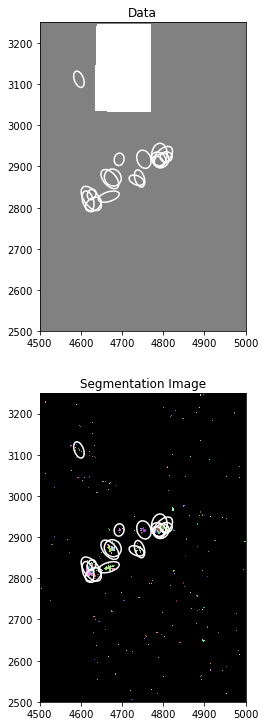

In [98]:
from astropy.visualization import simple_norm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.set_title('Data')
ax2.set_title('Segmentation Image')

img_choice = [1]
for i in img_choice:
    apertures = cat_list[i].kron_aperture
    patches = []
    for aperture in apertures:
        if aperture is not None and aperture.a > 10. and aperture.b > 10.:
            aperture.plot(axes=ax1, color='white', lw=1.5)
            aperture.plot(axes=ax2, color='white', lw=1.5)
            patches.append(aperture._to_patch())

    norm = simple_norm(data_bkg_subtracted[i], 'sqrt')
    ax1.imshow(data_bkg_subtracted[i], origin='lower', cmap='Greys_r', norm=norm)

    cmap = segm_deblend_list[i].make_cmap(seed=123)
    ax2.imshow(segm_deblend_list[i], origin='lower', cmap=cmap, interpolation='nearest')
    
ax1.set_xlim(4500, 5000)
ax1.set_ylim(2500, 3250)

ax2.set_xlim(4500, 5000)
ax2.set_ylim(2500, 3250)